In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

algos = ['DQN', 'BCQ', 'CQL']
nr_trajs = [100, 1000, 10000, 50000, 100000]
opts = [0, 25, 50, 75, 100]
seeds = range(1, 4)
output_dir = 'plots'

base_path = 'd3rlpy_logs'
os.makedirs(output_dir, exist_ok=True)

def load_and_process_data(filename_template):
    all_data = []
    for algo in algos:
        for nr_traj in nr_trajs:
            for opt in opts:
                dfs = []
                for seed in seeds:
                    file_path = os.path.join(base_path, f"{algo}_nr_traj_{nr_traj}_opt_{opt}_seed_{seed}", filename_template)
                    if os.path.exists(file_path):
                        try:
                            df = pd.read_csv(file_path, header=None)
                            if df.empty:
                                print(f"File is empty: {file_path}")
                                continue
                            if df.shape[1] >= 3:
                                df = df.iloc[:, :3] 
                                df.columns = ['Epoch', 'Timestep', 'Value']
                                # Check if the 'Value' column needs to be cleaned
                                if df['Value'].dtype == object:
                                    df['Value'] = df['Value'].apply(lambda x: np.mean([float(num) for num in re.findall(r"-?\d+\.\d+", x)]))
                                dfs.append(df)
                        except pd.errors.EmptyDataError:
                            print(f"Caught EmptyDataError for file: {file_path}")
                            continue
                    else:
                        print(f"File not found: {file_path}")  # Indicate file not found

                if dfs:
                    combined_df = pd.concat(dfs).groupby(['Epoch', 'Timestep']).mean().reset_index()
                    combined_df['Algo'] = algo
                    combined_df['Nr_traj'] = nr_traj
                    combined_df['Opt'] = opt
                    all_data.append(combined_df)
                else:
                    print(f"No data loaded for {algo} with nr_traj {nr_traj} and opt {opt}")
    
    return pd.concat(all_data) if all_data else None

# Load and process data again
loss_data = load_and_process_data('loss.csv')
env_eval_data = load_and_process_data('evaluation_env.csv')
fqe_eval_data = load_and_process_data('evaluation_fqe.csv')
magic_eval_data = load_and_process_data('evaluation_magic.csv')



/Users/davidstreuli/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/davidstreuli/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_0_seed_1/evaluation_magic.csv
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_0_seed_2/evaluation_magic.csv
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_0_seed_3/evaluation_magic.csv
No data loaded for DQN with nr_traj 50000 and opt 0
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_25_seed_1/evaluation_magic.csv
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_25_seed_2/evaluation_magic.csv
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_25_seed_3/evaluation_magic.csv
No data loaded for DQN with nr_traj 50000 and opt 25
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_50_seed_1/evaluation_magic.csv
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_50_seed_2/evaluation_magic.csv
Caught EmptyDataError for file: d3rlpy_logs/DQN_nr_traj_50000_opt_50_seed_3/evaluation_magic.csv
No data loaded for DQN wi

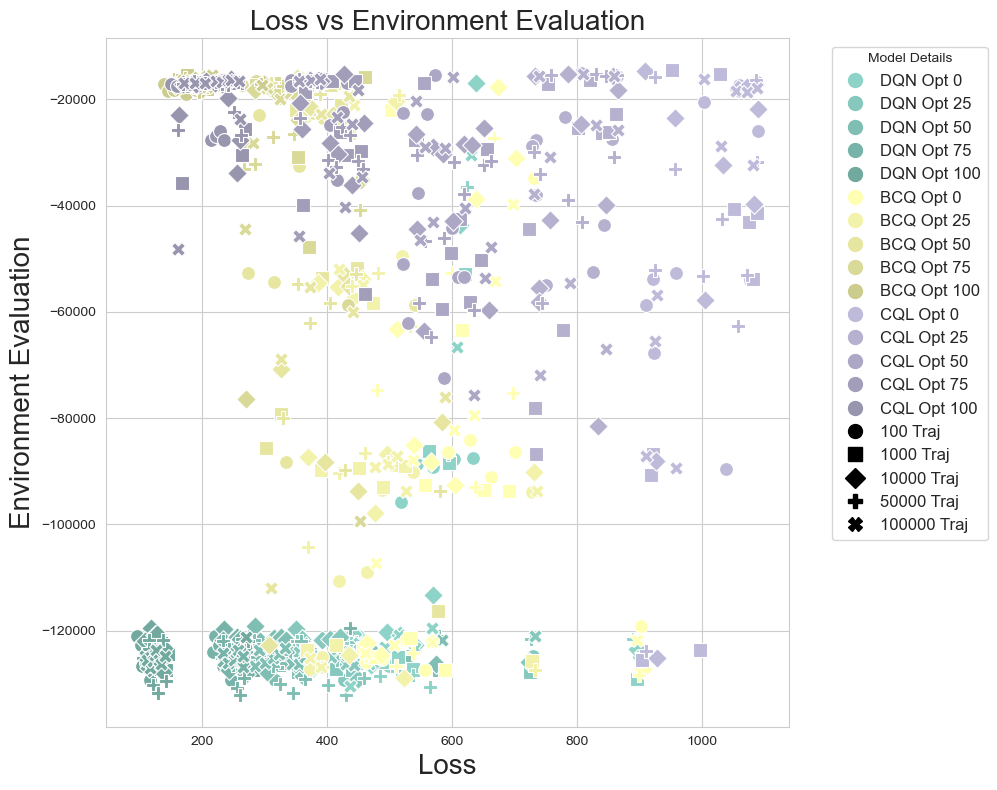

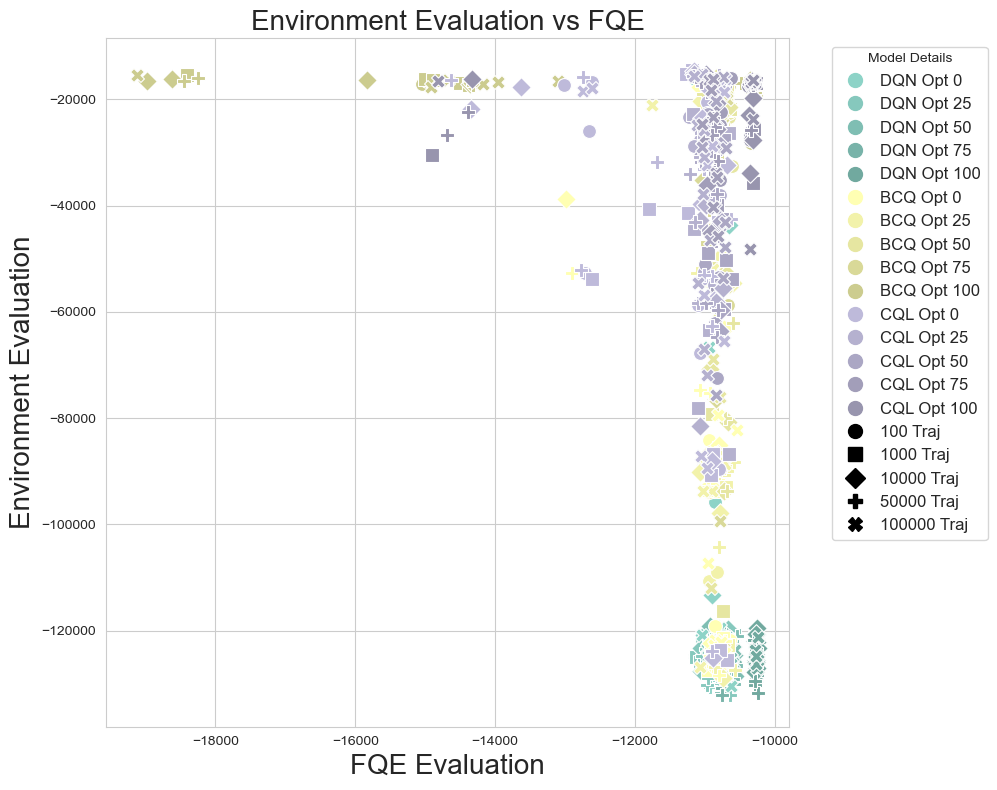

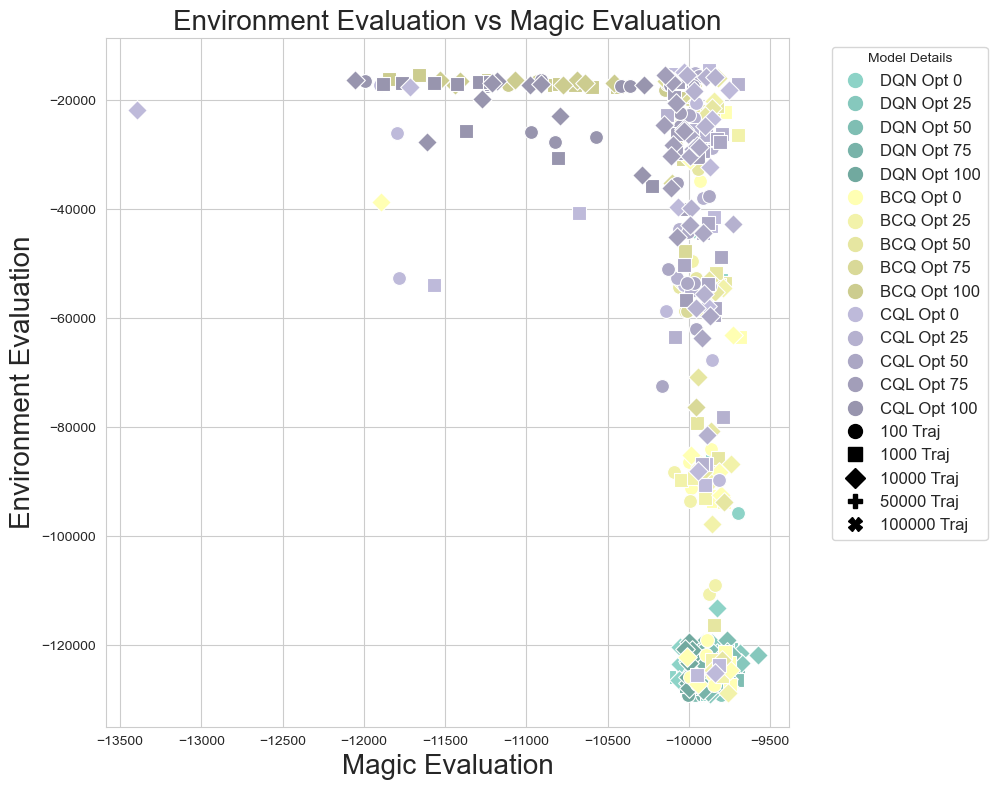

In [91]:
palette = sns.color_palette("Set3", n_colors=len(algos))
algo_colors = dict(zip(algos, palette))

sns.set_style("whitegrid")

def adjust_color(color, factor):
    r, g, b = color
    return (max(min(r * factor, 1), 0), max(min(g * factor, 1), 0), max(min(b * factor, 1), 0))

markers = {
    100: "o",    # Circle
    1000: "s",   # Square
    10000: "D",  # Diamond
    50000: "P",  # Plus-filled
    100000: "X"  # X-filled
}

# Function to get the marker for a given dataset size
def marker_mapper(nr_traj):
    return markers.get(nr_traj, "^")  

# Function to merge datasets and plot with variable marker sizes and styles
def merge_and_plot(x_data, y_data, x_label, y_label, title, filename):
    # Rename columns for clarity in merging
    x_data = x_data.rename(columns={'Value': f'{x_label}'})
    y_data = y_data.rename(columns={'Value': f'{y_label}'})
    
    # Merging data on common columns
    merged_data = pd.merge(x_data, y_data, on=["Epoch", "Timestep", "Algo", "Nr_traj", "Opt"])
    
    plt.figure(figsize=(12, 8))
    plot_handles = {}  # To store custom handles for legend
    
    # Plot each subset with variable marker styles
    for algo in algos:
        for nr_traj in nr_trajs:
            marker = marker_mapper(nr_traj)
            for opt in opts:
                subset = merged_data[(merged_data['Algo'] == algo) & (merged_data['Nr_traj'] == nr_traj) & (merged_data['Opt'] == opt)]
                if not subset.empty:
                    color = adjust_color(algo_colors[algo], 1 - 0.05 * (opts.index(opt)))
                    plot = sns.scatterplot(data=subset, x=f'{y_label}', y=f'{x_label}', color=color, marker=marker, s=100)
                    if (algo, opt) not in plot_handles:
                        plot_handles[(algo, opt)] = plot.collections[-1]  # Save the last plotted item handle

    plt.xlabel(y_label, fontsize=20)
    plt.ylabel(x_label, fontsize=20)
    plt.title(title, fontsize=20)

    # Create custom legend for algorithms and optimality
    custom_legend = [plt.Line2D([0], [0], color=adjust_color(algo_colors[algo], 1 - 0.05 * (opts.index(opt))), marker='o', linestyle='', markersize=10)
                     for algo, opt in plot_handles.keys()]
    labels = [f'{algo} Opt {opt}' for algo, opt in plot_handles.keys()]
    
    # Annotate for dataset sizes using the markers dictionary, all in black color
    dataset_size_handles = [plt.Line2D([0], [0], color='black', marker=markers[nr_traj], linestyle='', markersize=10) for nr_traj in sorted(markers)]
    dataset_size_labels = [f'{nr_traj} Traj' for nr_traj in sorted(markers)]
    
    plt.legend(custom_legend + dataset_size_handles, labels + dataset_size_labels,
               title='Model Details', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, handletextpad=0.5, columnspacing=1, frameon=True)
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to fit the legend outside
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()


if loss_data is not None and env_eval_data is not None:
    merge_and_plot(env_eval_data, loss_data, 'Environment Evaluation', 'Loss', 'Loss vs Environment Evaluation', 'loss_vs_env_eval.png')

if env_eval_data is not None and fqe_eval_data is not None:
    merge_and_plot(env_eval_data, fqe_eval_data, 'Environment Evaluation', 'FQE Evaluation', 'Environment Evaluation vs FQE', 'env_eval_vs_fqe.png')

if env_eval_data is not None and magic_eval_data is not None:
    merge_and_plot(env_eval_data, magic_eval_data, 'Environment Evaluation', 'Magic Evaluation', 'Environment Evaluation vs Magic Evaluation', 'env_eval_vs_magic.png')